# Seamless Image Cloning (Algebraic)

The purpose of this code is to demonstrate the seamless image cloning algorithm. See [1] for details.

[1] http://www.cs.jhu.edu/~misha/Fall07/Papers/Perez03.pdf

## compute naive clone

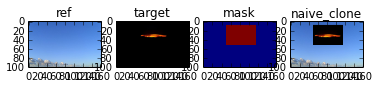

In [1]:
%matplotlib inline 

import PIL
import PIL.Image
import scipy
import numpy
import matplotlib.pyplot
import scipy.misc

ref = PIL.Image.open("dest.jpg")
ref = numpy.array(ref)
ref = scipy.misc.imresize(ref, 0.25, interp="bicubic")

target                        = PIL.Image.open("source.jpg")
target                        = numpy.array(target)
target                        = scipy.misc.imresize(target, 0.25, interp="bicubic")
target_array_rgb              = numpy.array(target)
target_array_rgb_resized      = scipy.misc.imresize(target, 0.5, interp="bicubic")

rny = ref.shape[0]
rnx = ref.shape[1]
tny = target_array_rgb_resized.shape[0]
tnx = target_array_rgb_resized.shape[1]
oy  = 10
ox  = 50

target_array_rgb_resized_view = target_array_rgb_resized.view(dtype=[("r", numpy.uint8), ("g", numpy.uint8), ("b", numpy.uint8)]).squeeze()
zeros                         = numpy.zeros_like(ref)
zeros_view                    = zeros.view(dtype=[("r", numpy.uint8), ("g", numpy.uint8), ("b", numpy.uint8)]).squeeze()
target                        = zeros_view.copy()
target[oy:oy+tny, ox:ox+tnx]  = target_array_rgb_resized_view
target                        = numpy.reshape(target.view(dtype=numpy.uint8), ref.shape)

mask                       = numpy.zeros((rny,rnx), dtype=numpy.uint8)
mask[oy:oy+tny, ox:ox+tnx] = 1

naive_clone                = ref.copy()
naive_clone[mask == 1]     = target[mask == 1]



matplotlib.pyplot.subplot(141)
matplotlib.pyplot.imshow(ref);
matplotlib.pyplot.title("ref");

matplotlib.pyplot.subplot(142)
matplotlib.pyplot.imshow(target);
matplotlib.pyplot.title("target");

matplotlib.pyplot.subplot(143)
matplotlib.pyplot.imshow(mask);
matplotlib.pyplot.title("mask");

matplotlib.pyplot.subplot(144)
matplotlib.pyplot.imshow(naive_clone);
matplotlib.pyplot.title("naive_clone");

## compute strict interior and border regions, as well as variable index map

In [2]:
import skimage
import skimage.morphology

strict_interior = skimage.morphology.erosion(mask, numpy.ones((3,3), dtype=numpy.uint8))
border          = mask - strict_interior
strict_interior = mask

strict_interior_indices                     = strict_interior.nonzero()
num_strict_interior_pixels                  = strict_interior_indices[0].shape[0]
variable_index_map                          = -1 * numpy.ones_like(mask, dtype=numpy.int32)
variable_index_map[strict_interior_indices] = numpy.arange(num_strict_interior_pixels)

matplotlib.pyplot.subplot(121);
matplotlib.pyplot.imshow(strict_interior, interpolation="nearest");
matplotlib.pyplot.title("strict_interior");

matplotlib.pyplot.subplot(122);
matplotlib.pyplot.imshow(variable_index_map);
matplotlib.pyplot.title("variable_index_map");

ImportError: No module named skimage

## compute seamless clone (red)

We compute a seamless clone by solving for the unknown pixel values inside a masked region. The seamless cloning algorithm operates only greyscale images, so we apply it each color channel independently. For each pixel location $p$ in the strict interior of the masked region $\Omega$, we relate the intensities of the unknown, source, and destination pixel values as follows:

$$|N_p|f_p - \sum_{q\in N_p \cap \Omega} f_q = \sum_{q\in N_p \cap \delta \Omega} f_q^* + \sum_{q\in N_p} (g_p - g_q)$$

where:

- $N_p$ is the set of $p$'s 4-connected neighbors (note that $|N_p|$ might be less than 4 if $\Omega$ extends to the image border);

- $f_p$ is the unknown intensity value at $p$;

- $f_q^*$ is the known intensity value from the destination image in the border of the masked region $\delta \Omega$; and

- $g_p$ is the known intensity value from the source image at $p$, and $g_q$ is the known intensity value from the source image at $q \in N_p$

In [3]:
import scipy
import scipy.sparse
import scipy.sparse.linalg

ref_greyscale    = ref[:,:,0].copy()
target_greyscale = target[:,:,0].copy()

A = scipy.sparse.dok_matrix((num_strict_interior_pixels,num_strict_interior_pixels), dtype=numpy.float32)
B = numpy.zeros(num_strict_interior_pixels, dtype=numpy.float32)

for i in range(num_strict_interior_pixels):
    
    y = strict_interior_indices[0][i]
    x = strict_interior_indices[1][i]
    
    x_right = x+1
    x_left  = x-1

    y_up    = y-1
    y_down  = y+1

    assert( i == variable_index_map[y,x] )
    
    x_neighbors                = []
    y_neighbors                = []
    variable_indices_neighbors = []
    
    if x_right < rnx:
        y_neighbors.append(y)
        x_neighbors.append(x_right)
        variable_indices_neighbors.append(variable_index_map[y,x_right])
        
    if y_up >= 0:
        y_neighbors.append(y_up)
        x_neighbors.append(x)
        variable_indices_neighbors.append(variable_index_map[y_up,x])

    if x_left >= 0:
        y_neighbors.append(y)
        x_neighbors.append(x_left)
        variable_indices_neighbors.append(variable_index_map[y,x_left])

    if y_down < rny:
        y_neighbors.append(y_down)
        x_neighbors.append(x)
        variable_indices_neighbors.append(variable_index_map[y_down,x])

    y_neighbors                                = numpy.array(y_neighbors)
    x_neighbors                                = numpy.array(x_neighbors)
    variable_indices_neighbors                 = numpy.array(variable_indices_neighbors)
    variable_indices_neighbors_strict_interior = (variable_indices_neighbors != -1).nonzero()
    variable_indices_neighbors_border          = (variable_indices_neighbors == -1).nonzero()
    num_neighbors                              = y_neighbors.shape[0]

    sum_vq       = (num_neighbors * target_greyscale[y,x]) - numpy.sum(target_greyscale[(y_neighbors, x_neighbors)])
    sum_border_f = numpy.sum(ref_greyscale[(y_neighbors[variable_indices_neighbors_border],x_neighbors[variable_indices_neighbors_border])])
    
    A[i,i]                                                                         = num_neighbors
    A[i,variable_indices_neighbors[variable_indices_neighbors_strict_interior[0]]] = -1
    B[i]                                                                           = sum_vq #+ sum_border_f

X_r, stop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = scipy.sparse.linalg.lsqr(A, B, iter_lim=10000, show=False)

NameError: name 'num_strict_interior_pixels' is not defined

## compute seamless clone (green)

In [ ]:
import scipy
import scipy.sparse
import scipy.sparse.linalg

ref_greyscale    = ref[:,:,1].copy()
target_greyscale = target[:,:,1].copy()

A = scipy.sparse.dok_matrix((num_strict_interior_pixels,num_strict_interior_pixels), dtype=numpy.float32)
B = numpy.zeros(num_strict_interior_pixels, dtype=numpy.float32)

for i in range(num_strict_interior_pixels):
    
    y = strict_interior_indices[0][i]
    x = strict_interior_indices[1][i]
    
    x_right = x+1
    x_left  = x-1

    y_up    = y-1
    y_down  = y+1

    assert( i == variable_index_map[y,x] )
    
    x_neighbors                = []
    y_neighbors                = []
    variable_indices_neighbors = []
    
    if x_right < rnx:
        y_neighbors.append(y)
        x_neighbors.append(x_right)
        variable_indices_neighbors.append(variable_index_map[y,x_right])
        
    if y_up >= 0:
        y_neighbors.append(y_up)
        x_neighbors.append(x)
        variable_indices_neighbors.append(variable_index_map[y_up,x])

    if x_left >= 0:
        y_neighbors.append(y)
        x_neighbors.append(x_left)
        variable_indices_neighbors.append(variable_index_map[y,x_left])

    if y_down < rny:
        y_neighbors.append(y_down)
        x_neighbors.append(x)
        variable_indices_neighbors.append(variable_index_map[y_down,x])

    y_neighbors                                = numpy.array(y_neighbors)
    x_neighbors                                = numpy.array(x_neighbors)
    variable_indices_neighbors                 = numpy.array(variable_indices_neighbors)
    variable_indices_neighbors_strict_interior = (variable_indices_neighbors != -1).nonzero()
    variable_indices_neighbors_border          = (variable_indices_neighbors == -1).nonzero()
    num_neighbors                              = y_neighbors.shape[0]
    
    sum_vq       = (num_neighbors * target_greyscale[y,x]) - numpy.sum(target_greyscale[(y_neighbors, x_neighbors)])
    sum_border_f = numpy.sum(ref_greyscale[(y_neighbors[variable_indices_neighbors_border],x_neighbors[variable_indices_neighbors_border])])
    
    A[i,i]                                                                         = num_neighbors
    A[i,variable_indices_neighbors[variable_indices_neighbors_strict_interior[0]]] = -1
    B[i]                                                                           = sum_vq #+ sum_border_f

X_g, stop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = scipy.sparse.linalg.lsqr(A, B, iter_lim=10000, show=True)

## compute seamless clone (blue)

In [4]:
import scipy
import scipy.sparse
import scipy.sparse.linalg

ref_greyscale    = ref[:,:,2].copy()
target_greyscale = target[:,:,2].copy()

A = scipy.sparse.dok_matrix((num_strict_interior_pixels,num_strict_interior_pixels), dtype=numpy.float32)
B = numpy.zeros(num_strict_interior_pixels, dtype=numpy.float32)

for i in range(num_strict_interior_pixels):
    
    y = strict_interior_indices[0][i]
    x = strict_interior_indices[1][i]
    
    x_right = x+1
    x_left  = x-1

    y_up    = y-1
    y_down  = y+1

    assert( i == variable_index_map[y,x] )
    
    x_neighbors                = []
    y_neighbors                = []
    variable_indices_neighbors = []
    
    if x_right < rnx:
        y_neighbors.append(y)
        x_neighbors.append(x_right)
        variable_indices_neighbors.append(variable_index_map[y,x_right])
        
    if y_up >= 0:
        y_neighbors.append(y_up)
        x_neighbors.append(x)
        variable_indices_neighbors.append(variable_index_map[y_up,x])

    if x_left >= 0:
        y_neighbors.append(y)
        x_neighbors.append(x_left)
        variable_indices_neighbors.append(variable_index_map[y,x_left])

    if y_down < rny:
        y_neighbors.append(y_down)
        x_neighbors.append(x)
        variable_indices_neighbors.append(variable_index_map[y_down,x])

    y_neighbors                                = numpy.array(y_neighbors)
    x_neighbors                                = numpy.array(x_neighbors)
    variable_indices_neighbors                 = numpy.array(variable_indices_neighbors)
    variable_indices_neighbors_strict_interior = (variable_indices_neighbors != -1).nonzero()
    variable_indices_neighbors_border          = (variable_indices_neighbors == -1).nonzero()
    num_neighbors                              = y_neighbors.shape[0]
    
    sum_vq       = (num_neighbors * target_greyscale[y,x]) - numpy.sum(target_greyscale[(y_neighbors, x_neighbors)])
    sum_border_f = numpy.sum(ref_greyscale[(y_neighbors[variable_indices_neighbors_border],x_neighbors[variable_indices_neighbors_border])])
    
    A[i,i]                                                                         = num_neighbors
    A[i,variable_indices_neighbors[variable_indices_neighbors_strict_interior[0]]] = -1
    B[i]                                                                           = sum_vq #+ sum_border_f

X_b, stop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = scipy.sparse.linalg.lsqr(A, B, iter_lim=10000, show=False)

NameError: name 'num_strict_interior_pixels' is not defined

In [5]:
ref_r,ref_g,ref_b = numpy.split(ref, 3, axis=2)

seamless_clone_r = ref_r.squeeze().copy()
seamless_clone_g = ref_g.squeeze().copy()
seamless_clone_b = ref_b.squeeze().copy()

seamless_clone_r[strict_interior_indices] = numpy.clip(X_r,0,255)
seamless_clone_g[strict_interior_indices] = numpy.clip(X_g,0,255)
seamless_clone_b[strict_interior_indices] = numpy.clip(X_b,0,255)

seamless_clone = \
    numpy.concatenate((seamless_clone_r[:,:,numpy.newaxis], seamless_clone_g[:,:,numpy.newaxis],seamless_clone_b[:,:,numpy.newaxis]), axis=2).copy()



matplotlib.pyplot.subplot(141)
matplotlib.pyplot.imshow(ref);
matplotlib.pyplot.title("ref");

matplotlib.pyplot.subplot(142)
matplotlib.pyplot.imshow(target);
matplotlib.pyplot.title("target");

matplotlib.pyplot.subplot(143)
matplotlib.pyplot.imshow(naive_clone);
matplotlib.pyplot.title("naive_clone");

matplotlib.pyplot.subplot(144)
matplotlib.pyplot.imshow(seamless_clone);
matplotlib.pyplot.title("seamless_clone");

NameError: name 'X_r' is not defined

NameError: name 'seamless_clone' is not defined

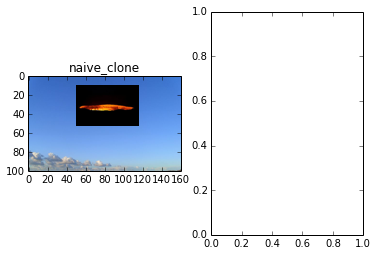

In [6]:


matplotlib.pyplot.subplot(121)
matplotlib.pyplot.imshow(naive_clone, interpolation="nearest");
matplotlib.pyplot.title("naive_clone");

matplotlib.pyplot.subplot(122)
matplotlib.pyplot.imshow(seamless_clone, interpolation="nearest");
matplotlib.pyplot.title("seamless_clone");